In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import time

In [2]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 4 GPUs.  Setting memory growth = True.


In [3]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel, make_opt_adam
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [4]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [5]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [6]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [7]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [8]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [9]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [10]:
# # Review unperturbed elements
# elts_ast

In [11]:
# Inputs to perturb elements: large
sigma_a = 0.05
sigma_e = 0.01
sigma_inc_deg = 0.25
sigma_f_deg = 1.0
sigma_Omega_deg = 1.0
sigma_omega_deg = 1.0
mask_pert = None
random_seed = 42

In [12]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
save_at_end: bool = True

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, ztf_elt=ztf_elt, 
                site_name=site_name, thresh_deg=thresh_deg, 
                learning_rate=learning_rate, clipnorm=clipnorm,
                name='model')

In [31]:
# Report before training starts
model.report()


Good elements (hits > 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean     :     0.84  :   0.00 :  1799.79 :  7200.00
Median   :     0.52  :   0.00 :  1792.82 :  7200.00
GeoMean  :     1.33  :   0.00 :  1799.77 :  7200.99
Std      :     1.56  :   0.00 :     7.19 :     0.00
Min      :    -1.56  :   0.00 :  1792.82 :  7200.00
Max      :     5.91  :   0.00 :  1807.21 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes.


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [32]:
raise ValueError

ValueError: 

## Automated Training with Sieve Method

In [33]:
# Set learning rates
learning_rate_frozen = 2.0**-12
learning_rate_thawed = 2.0**-15
# Minimum learning rate
min_learning_rate = 2.0**-20

# Episode sizes
num_batches_frozen = 500
num_batches_thawed = 2500

In [34]:
self = model


********************************************************************************
Round 1: 2000 batches @ LR 2^-12 with frozen elements.
********************************************************************************

Training episode 0: Epoch    0, Batch      0
effective_learning_rate=2.441e-04, training_time 0 sec.
Train on 6400 samples
Epoch 1/5
6400/6400 [==============================] - 4s 646us/sample - loss: -10807.7990
Epoch 2/5
6400/6400 [==============================] - 3s 393us/sample - loss: -20623.7233
Epoch 3/5
6400/6400 [==============================] - 2s 385us/sample - loss: -42016.0736
Epoch 4/5
6400/6400 [==============================] - 2s 387us/sample - loss: -87839.5012
Epoch 5/5
6400/6400 [==============================] - 3s 391us/sample - loss: -157163.7270
                    \  All Elts : Good Elts (0)
Geom Mean Resolution:   1355.10 :      nan arc seconds
Geom Mean Threshold :   7171.56 :      nan arc seconds
Mean Log Likelihood :     20.00 :      nan
M

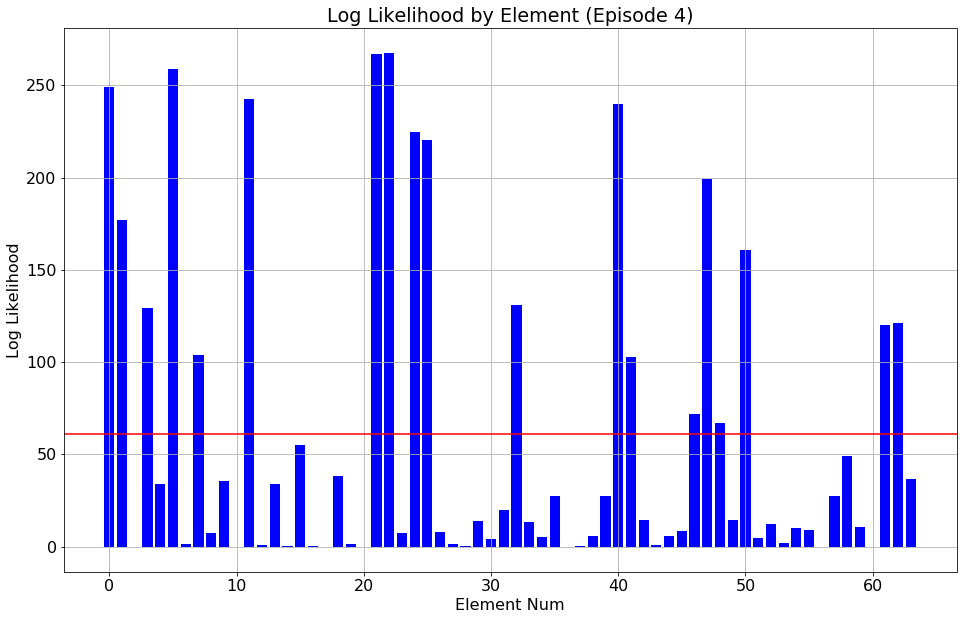

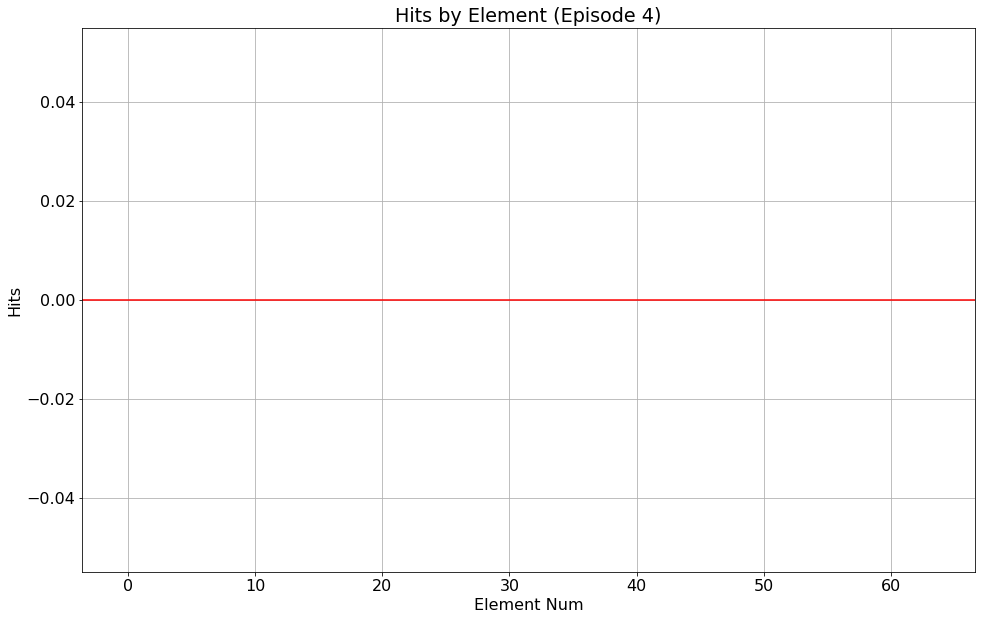

In [35]:
self.sieve_round(round=1, num_batches=2000, live_elts=False, 
                  learning_rate=learning_rate_frozen, min_learning_rate=min_learning_rate)


********************************************************************************
Round 2: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 4: Epoch   20, Batch   2000
effective_learning_rate=2.303e-04, training_time 69 sec.
Train on 6400 samples
Epoch 21/25
6400/6400 [==============================] - 5s 780us/sample - loss: -1395740.7113
Epoch 22/25
6400/6400 [==============================] - 3s 481us/sample - loss: -1516839.8025
Epoch 23/25
6400/6400 [==============================] - 3s 488us/sample - loss: -1596143.2250
Epoch 24/25
6400/6400 [==============================] - 3s 490us/sample - loss: -1677476.5962
Epoch 25/25
6400/6400 [==============================] - 3s 485us/sample - loss: -1758635.5075
                    \  All Elts : Good Elts (0)
Geom Mean Resolution:   1231.63 :      nan arc seconds
Geom Mean Thre

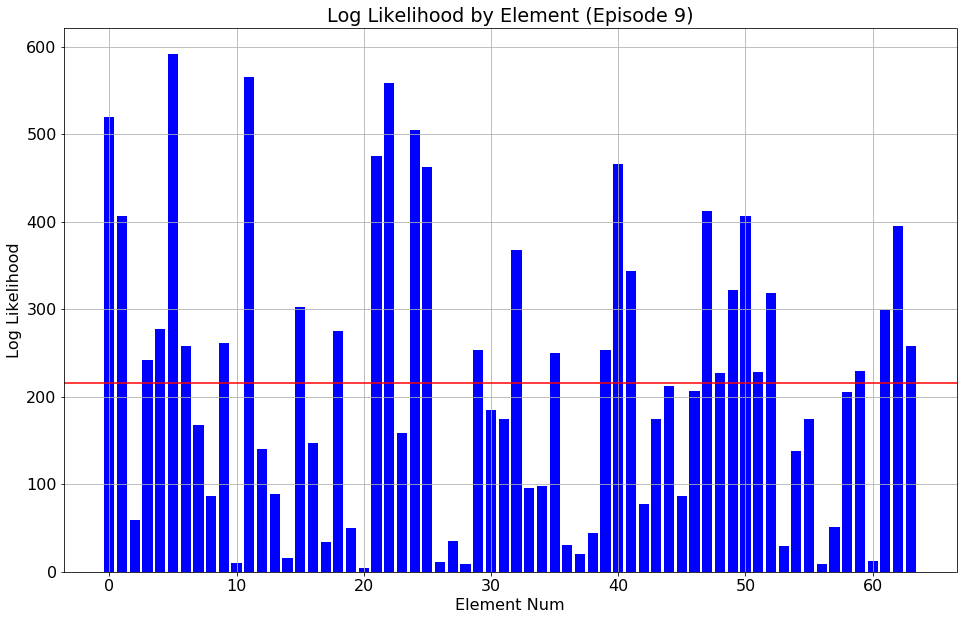

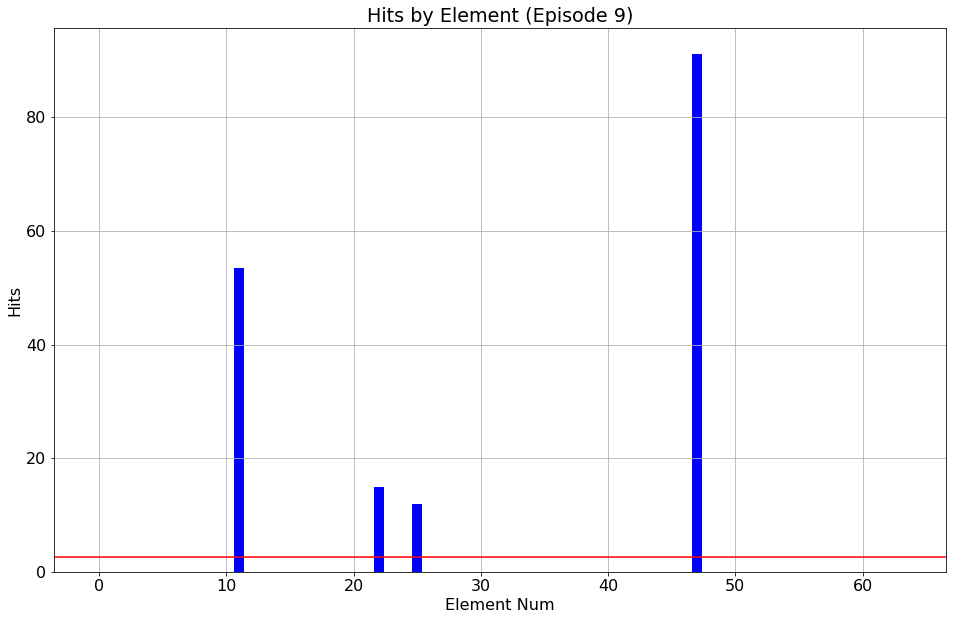

In [37]:
self.sieve_round(round=2, num_batches=num_batches_thawed, live_elts=True, 
                 learning_rate=learning_rate_thawed, min_learning_rate=min_learning_rate)


********************************************************************************
Round 3: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 2400.0
********************************************************************************

Training episode 9: Epoch   45, Batch   4500
effective_learning_rate=3.028e-05, training_time 215 sec.
Train on 6400 samples
Epoch 46/50
6400/6400 [==============================] - 4s 641us/sample - loss: -6707734.1850
Epoch 47/50
6400/6400 [==============================] - 3s 408us/sample - loss: -9251014.7550
Epoch 48/50
6400/6400 [==============================] - 3s 413us/sample - loss: -12797666.8700
Epoch 49/50
6400/6400 [==============================] - 3s 406us/sample - loss: -18241930.1100
Epoch 50/50
6400/6400 [==============================] - 3s 406us/sample - loss: -26977765.1800
                    \  All Elts : Good Elts (10)
Geom Mean Resolution:    295.75 :    54.93 arc seconds
Geom Mean Threshold :   1716.02 :   679.05 arc seco

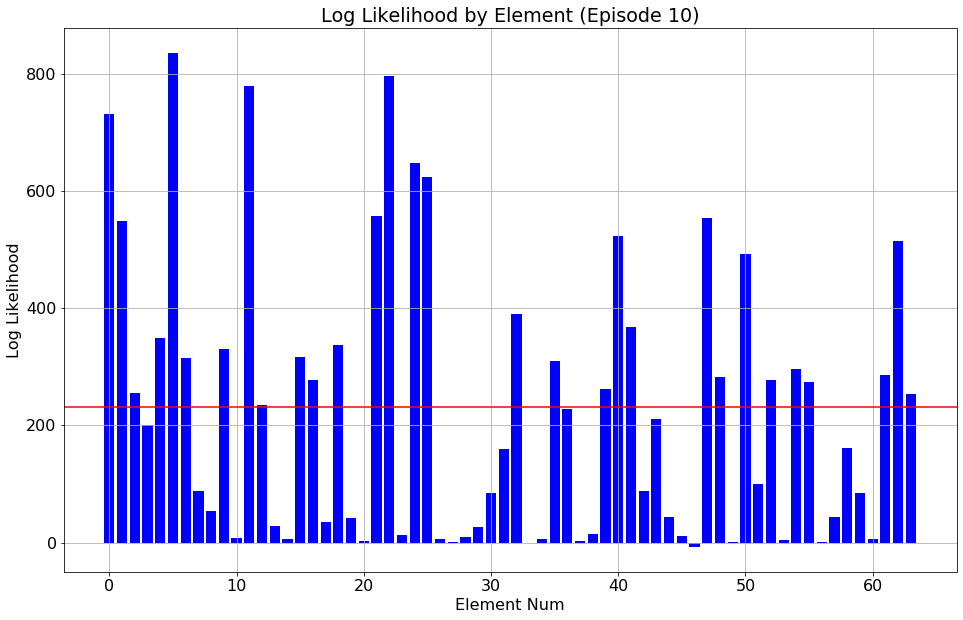

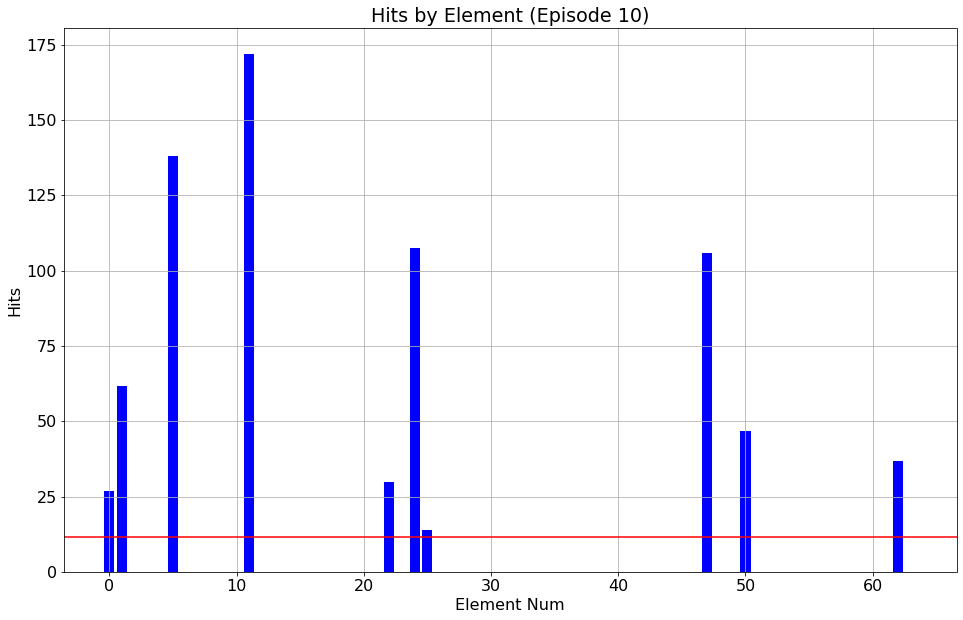

In [38]:
self.sieve_round(round=3, num_batches=num_batches_frozen, live_elts=False, 
                 learning_rate=learning_rate_frozen, min_learning_rate=min_learning_rate,
                 thresh_sec_max=2400.0)


********************************************************************************
Round 4: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 10: Epoch   50, Batch   5000
effective_learning_rate=3.028e-05, training_time 254 sec.
Train on 6400 samples
Epoch 51/55
6400/6400 [==============================] - 5s 797us/sample - loss: -26060391.4775
Epoch 52/55
6400/6400 [==============================] - 3s 513us/sample - loss: -28080001.8800
Epoch 53/55
6400/6400 [==============================] - 3s 515us/sample - loss: -29260411.2200
Epoch 54/55
6400/6400 [==============================] - 3s 493us/sample - loss: -30376601.1400
Epoch 55/55
6400/6400 [==============================] - 3s 490us/sample - loss: -31561264.1400
Adjusted element weight down on 4 candidate elements. Mean weight = 9.61e-01
                    \  All Elts :

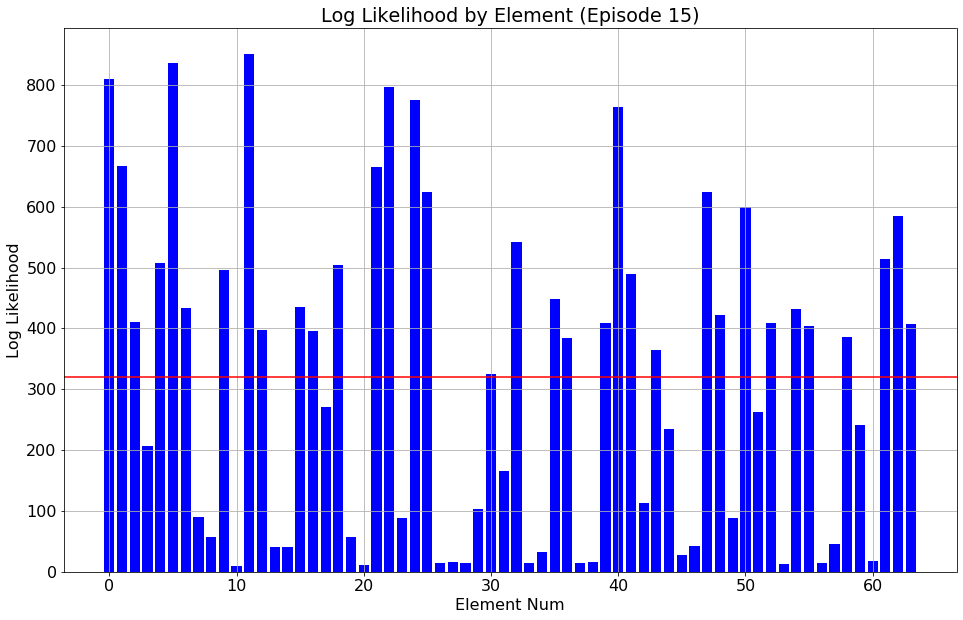

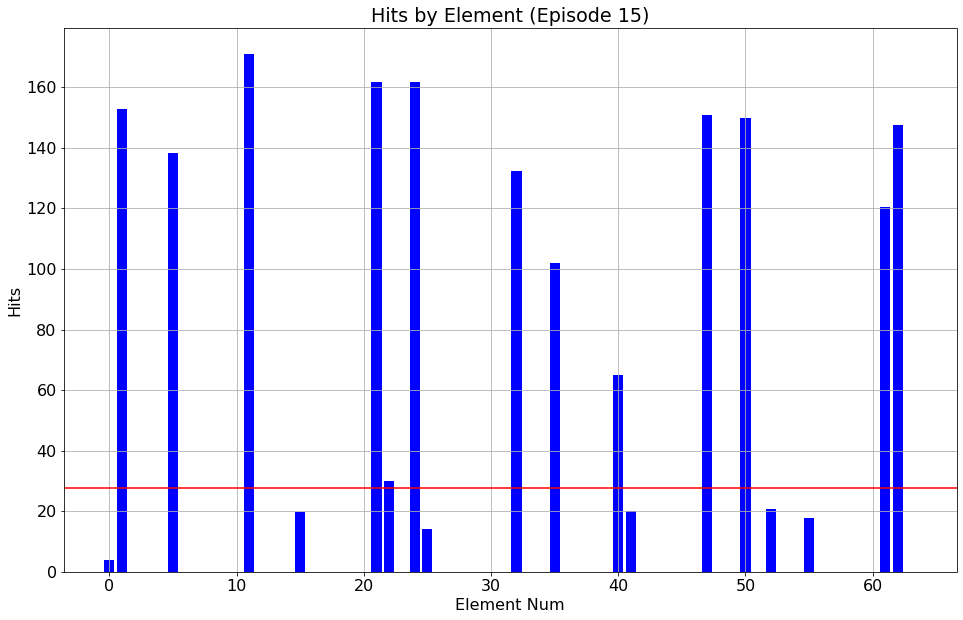

In [39]:
self.sieve_round(round=4, num_batches=num_batches_thawed, live_elts=True, 
                 learning_rate=learning_rate_thawed, min_learning_rate=min_learning_rate)


********************************************************************************
Round 5: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 1600.0
********************************************************************************

Training episode 15: Epoch   75, Batch   7500
effective_learning_rate=2.493e-05, training_time 361 sec.
Train on 6400 samples
Epoch 76/80
6400/6400 [==============================] - 4s 660us/sample - loss: -85472940.3200
Epoch 77/80
6400/6400 [==============================] - 3s 430us/sample - loss: -110340665.6800
Epoch 78/80
6400/6400 [==============================] - 3s 422us/sample - loss: -145761584.0000
Epoch 79/80
6400/6400 [==============================] - 3s 427us/sample - loss: -197232589.6000
Epoch 80/80
6400/6400 [==============================] - 3s 431us/sample - loss: -271923324.4800
Adjusted element weight down on 4 candidate elements. Mean weight = 9.12e-01
                    \  All Elts : Good Elts (27)
Geom Mean Resolution: 

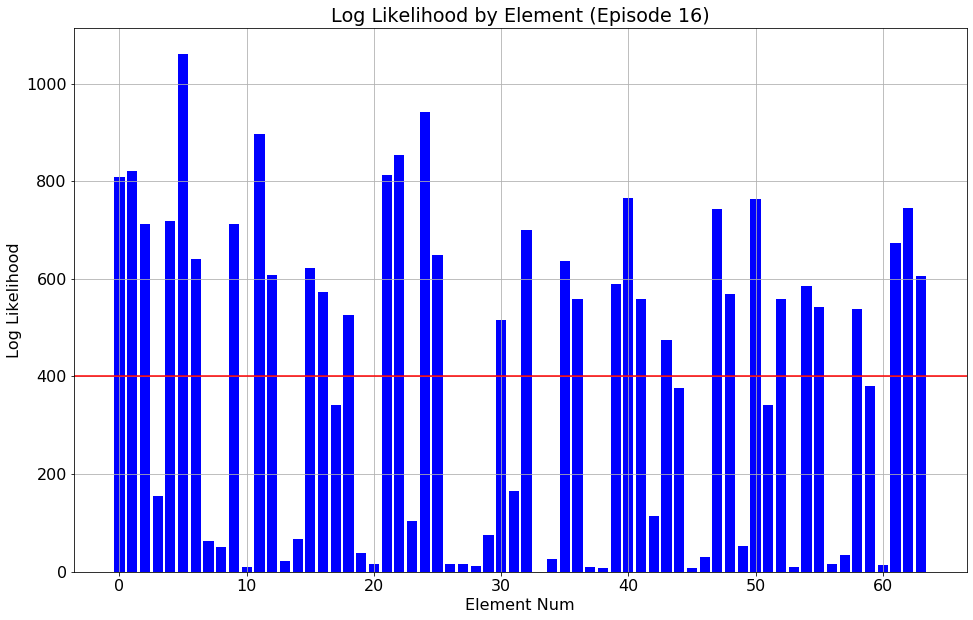

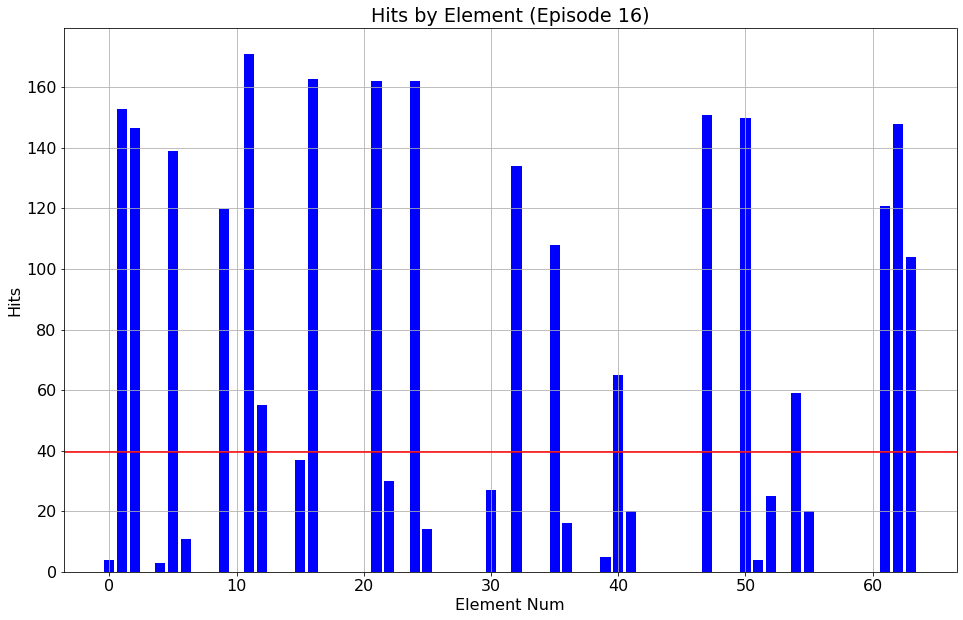

In [40]:
self.sieve_round(round=5, num_batches=num_batches_frozen, live_elts=False, 
                 learning_rate=learning_rate_frozen, min_learning_rate=min_learning_rate,
                 thresh_sec_max=1600.0)


********************************************************************************
Round 6: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 16: Epoch   80, Batch   8000
effective_learning_rate=2.227e-04, training_time 379 sec.
Train on 6400 samples
Epoch 81/85
6400/6400 [==============================] - 5s 843us/sample - loss: -53496915.3100
Epoch 82/85
6400/6400 [==============================] - 3s 540us/sample - loss: -59689050.0800
Epoch 83/85
6400/6400 [==============================] - 3s 541us/sample - loss: -61996338.4800
Epoch 84/85
6400/6400 [==============================] - 3s 530us/sample - loss: -64369669.6000
Epoch 85/85
6400/6400 [==============================] - 3s 546us/sample - loss: -66829980.4400
Adjusted element weight down on 25 candidate elements. Mean weight = 6.67e-01
                    \  All Elts 

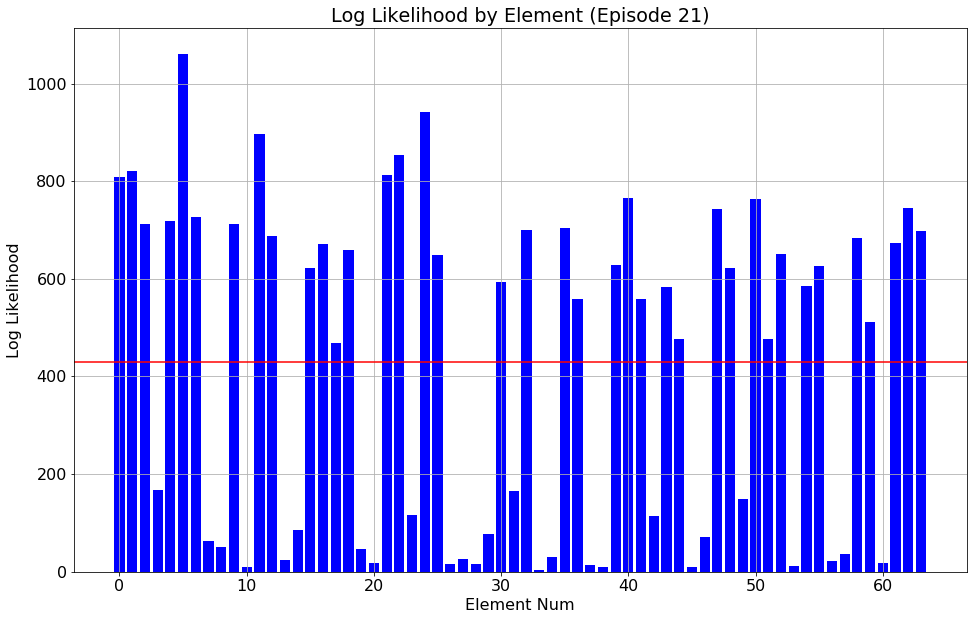

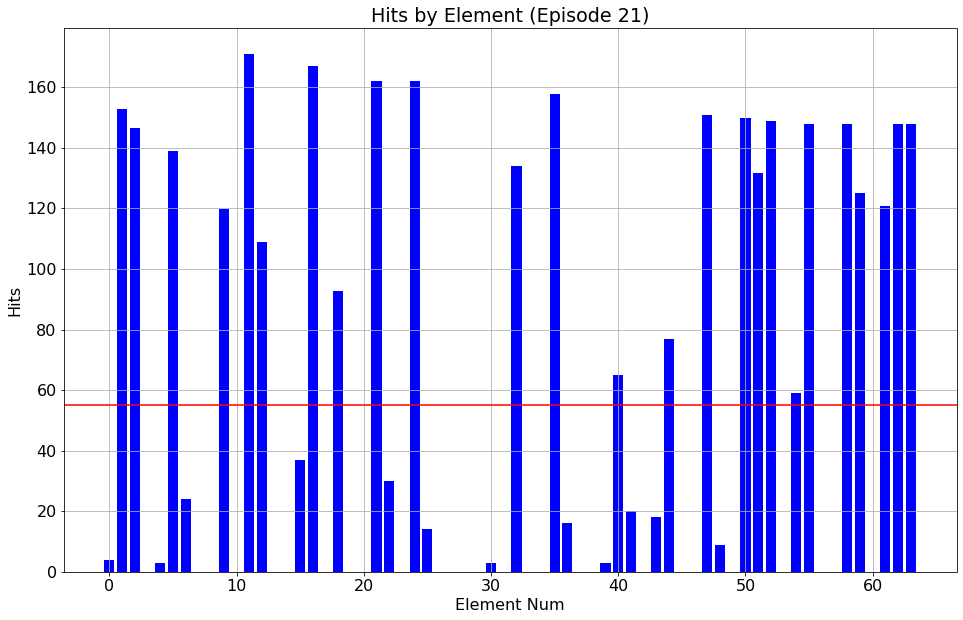

In [41]:
self.sieve_round(round=6, num_batches=num_batches_thawed, live_elts=True, 
                 learning_rate=learning_rate_thawed, min_learning_rate=min_learning_rate)


********************************************************************************
Round 7: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 800.0
********************************************************************************

Training episode 21: Epoch  105, Batch  10500
effective_learning_rate=1.215e-05, training_time 476 sec.
Train on 6400 samples
Epoch 106/110
6400/6400 [==============================] - 5s 759us/sample - loss: -414926846.4000
Epoch 107/110
6400/6400 [==============================] - 3s 466us/sample - loss: -504249902.4000
Epoch 108/110
6400/6400 [==============================] - 3s 470us/sample - loss: -618824744.3200
Epoch 109/110
6400/6400 [==============================] - 3s 460us/sample - loss: -767059580.1600
Epoch 110/110
6400/6400 [==============================] - 3s 466us/sample - loss: -957147987.8400
Adjusted element weight down on 19 candidate elements. Mean weight = 7.96e-01
                    \  All Elts : Good Elts (32)
Geom Mean R

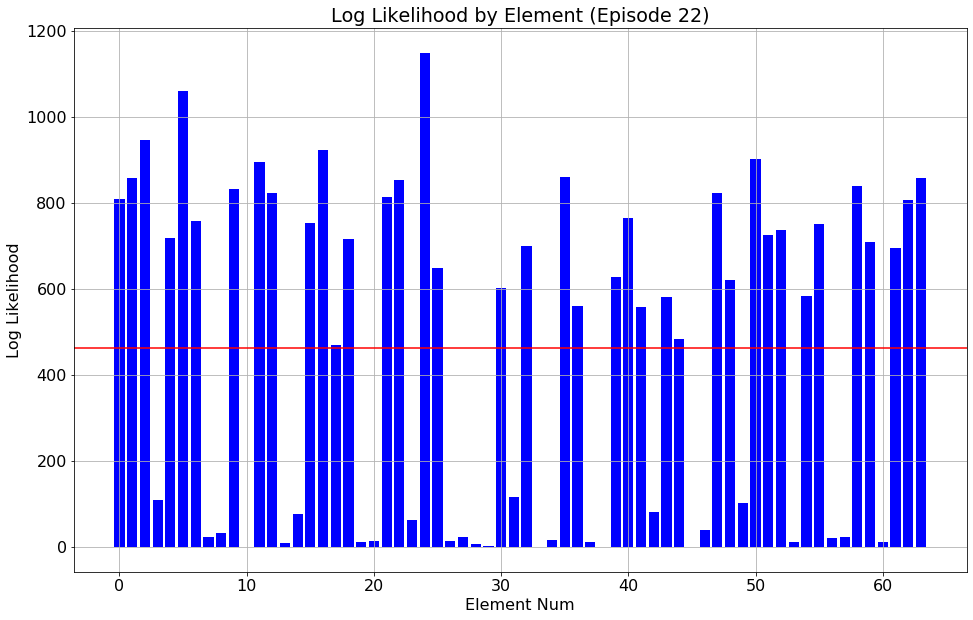

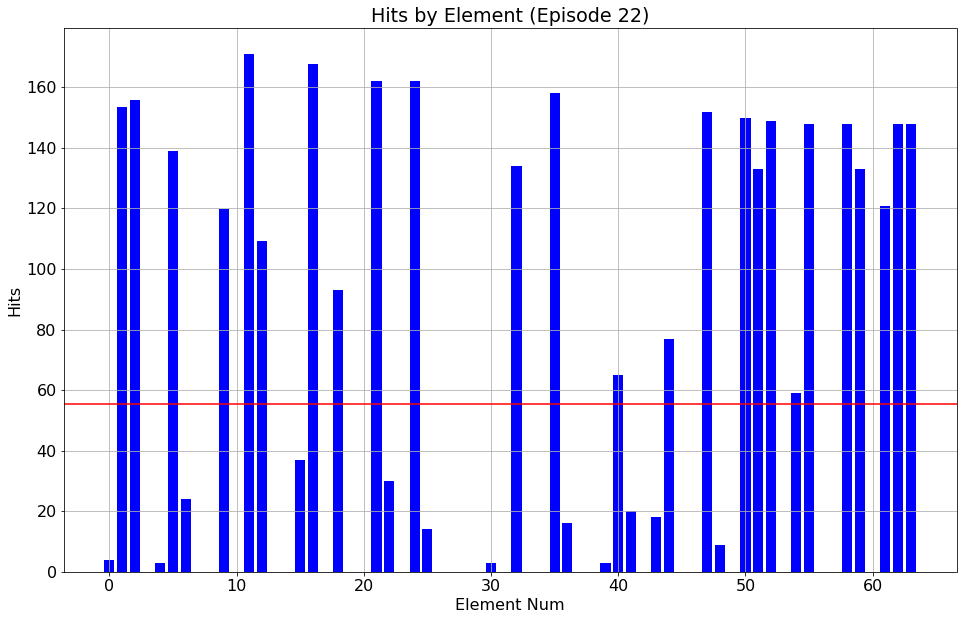

In [42]:
self.sieve_round(round=7, num_batches=num_batches_frozen, live_elts=False, 
                 learning_rate=learning_rate_frozen, min_learning_rate=min_learning_rate,
                 thresh_sec_max=800.0)


********************************************************************************
Round 8: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 22: Epoch  110, Batch  11000
effective_learning_rate=1.943e-04, training_time 495 sec.
Train on 6400 samples
Epoch 111/115
6400/6400 [==============================] - 5s 856us/sample - loss: -10098888.1713
Epoch 112/115
6400/6400 [==============================] - 4s 565us/sample - loss: -4291861.1375
Adjusted element weight down on 41 candidate elements. Mean weight = 2.95e-01
                    \  All Elts : Good Elts (32)
Geom Mean Resolution:     37.79 :     9.70 arc seconds
Geom Mean Threshold :    366.29 :   189.99 arc seconds
Mean Log Likelihood :    464.35 :   780.66
Mean Hits           :     55.26 :   109.84
Good Elements       :     32.00

Training episode 23: Epoch  112, Batch 

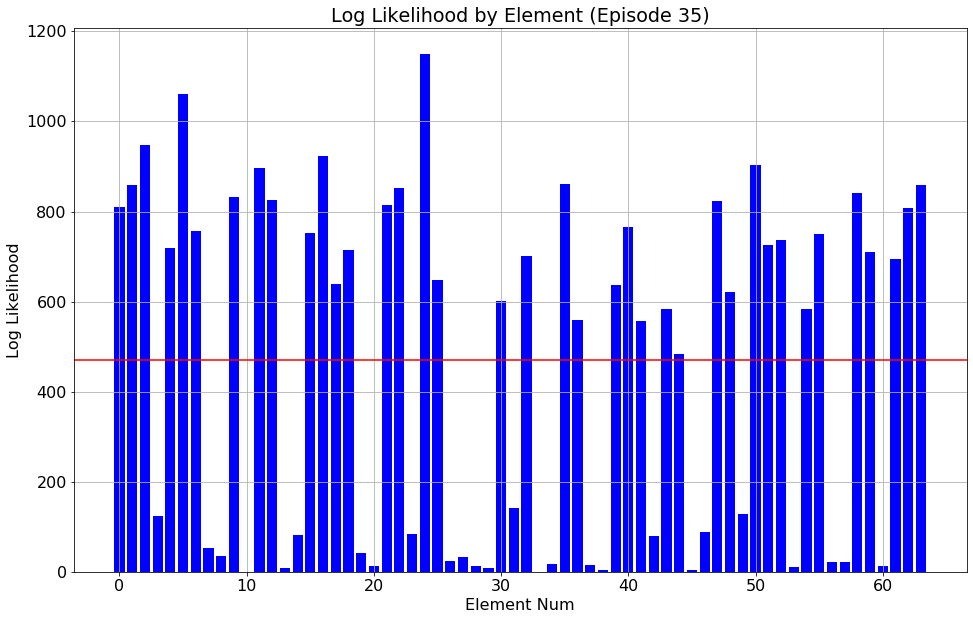

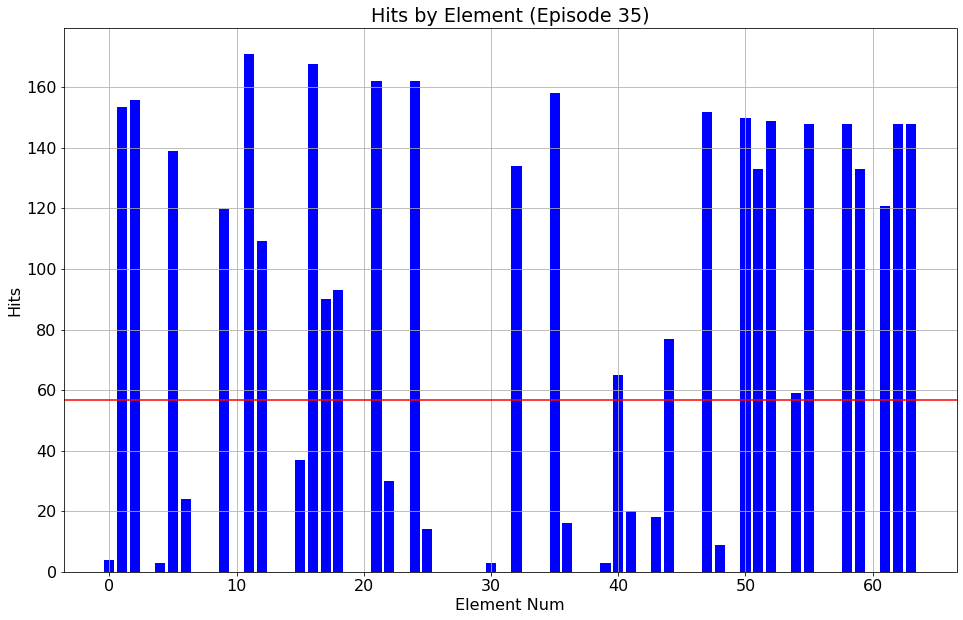

In [43]:
self.sieve_round(round=8, num_batches=num_batches_thawed, live_elts=True, 
                 learning_rate=learning_rate_thawed, min_learning_rate=min_learning_rate)


********************************************************************************
Round 9: 500 batches @ LR 2^-12 with frozen elements; thresh_sec_max = 400.0
********************************************************************************

Training episode 35: Epoch  136, Batch  13600
effective_learning_rate=1.893e-06, training_time 613 sec.
Train on 6400 samples
Epoch 137/141
6400/6400 [==============================] - 5s 773us/sample - loss: -888393670.4000
Epoch 138/141
6400/6400 [==============================] - 3s 537us/sample - loss: -1029828887.6800
Epoch 139/141
6400/6400 [==============================] - 3s 538us/sample - loss: -1193782119.6800
Epoch 140/141
6400/6400 [==============================] - 3s 531us/sample - loss: -1387198791.6800
Epoch 141/141
6400/6400 [==============================] - 3s 537us/sample - loss: -1619529080.3200
Adjusted element weight down on 33 candidate elements. Mean weight = 6.15e-01
                    \  All Elts : Good Elts (33)
Geom Me

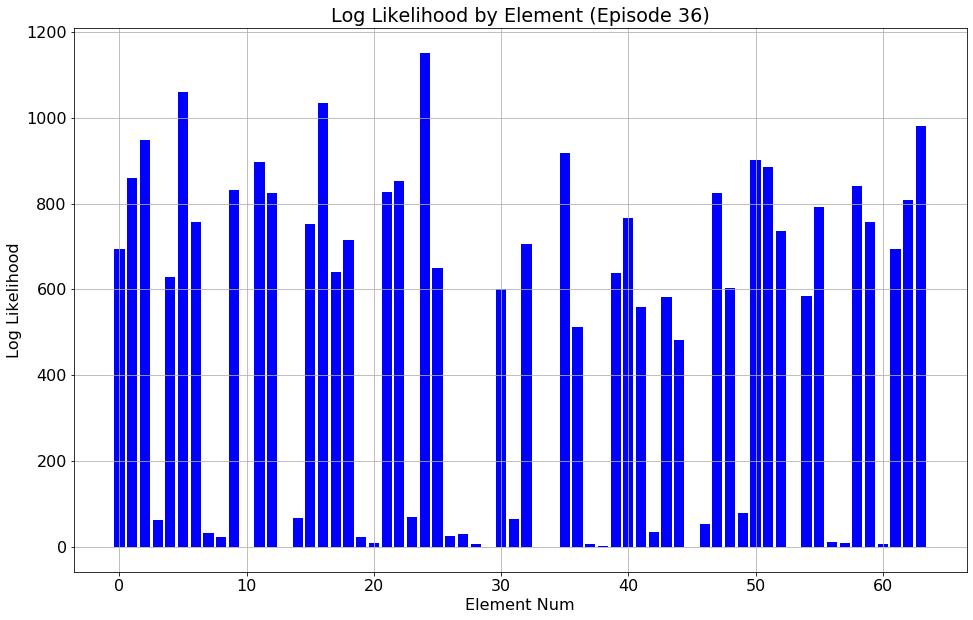

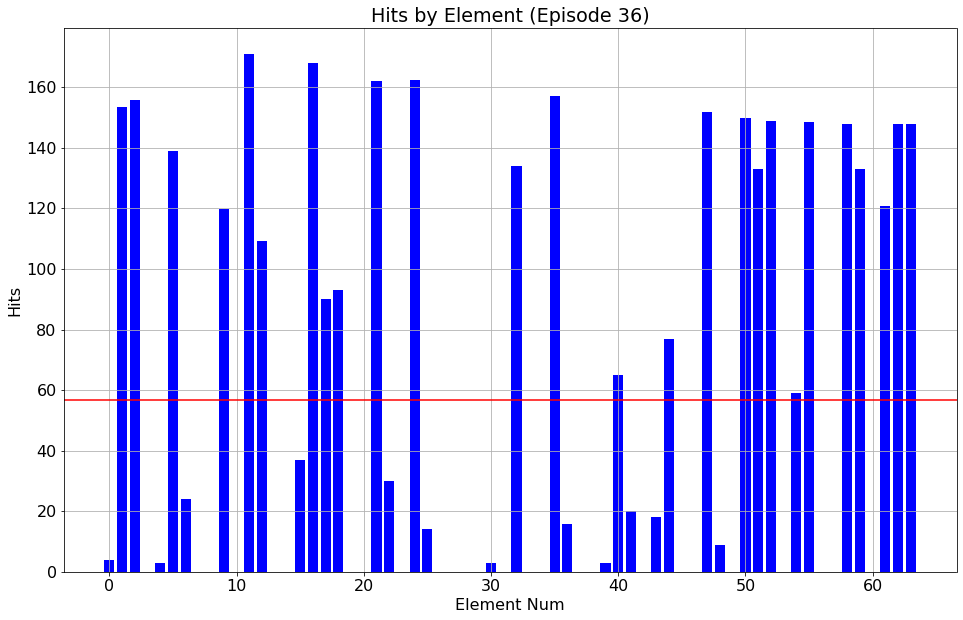

In [44]:
self.sieve_round(round=9, num_batches=num_batches_frozen, live_elts=False, 
                 learning_rate=learning_rate_frozen, min_learning_rate=min_learning_rate,
                 thresh_sec_max=400.0)


********************************************************************************
Round 10: 2500 batches @ LR 2^-15 with live elements.
********************************************************************************
Applying learning_rate 3.05e-05 (2.0^-15.0) for adaptive training.

Training episode 36: Epoch  141, Batch  14100
effective_learning_rate=1.501e-04, training_time 635 sec.
Train on 6400 samples
Epoch 142/146
6400/6400 [==============================] - 6s 933us/sample - loss: -12223913.7400
Epoch 143/146
6400/6400 [==============================] - 4s 640us/sample - loss: -3814884.2875
Adjusted element weight down on 47 candidate elements. Mean weight = 5.13e-02
                    \  All Elts : Good Elts (34)
Geom Mean Resolution:     28.81 :     8.23 arc seconds
Geom Mean Threshold :    248.18 :   169.09 arc seconds
Mean Log Likelihood :       nan :   787.83
Mean Hits           :     57.33 :   107.36
Good Elements       :     34.00

Training episode 37: Epoch  143, Batch

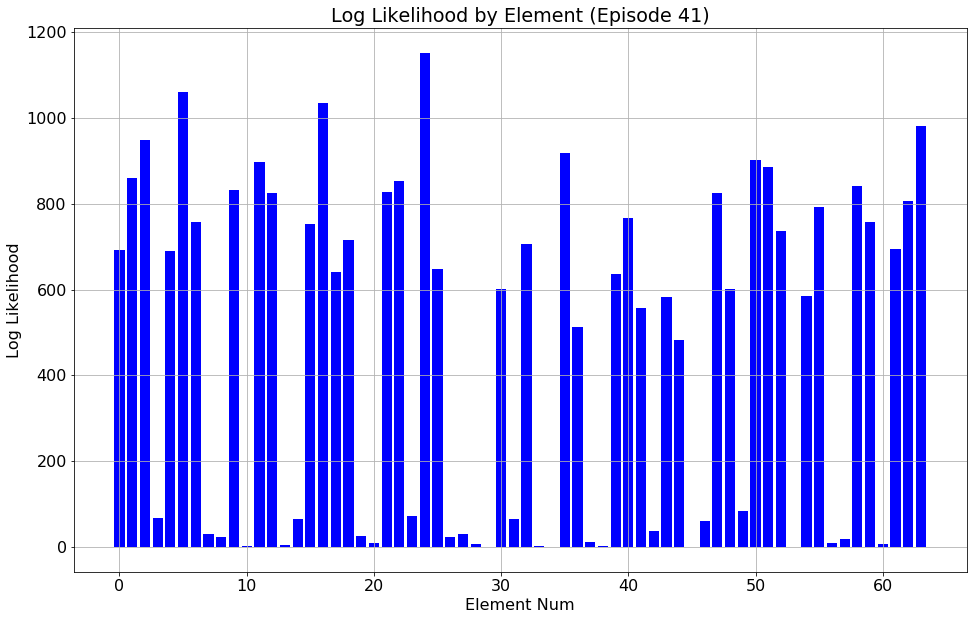

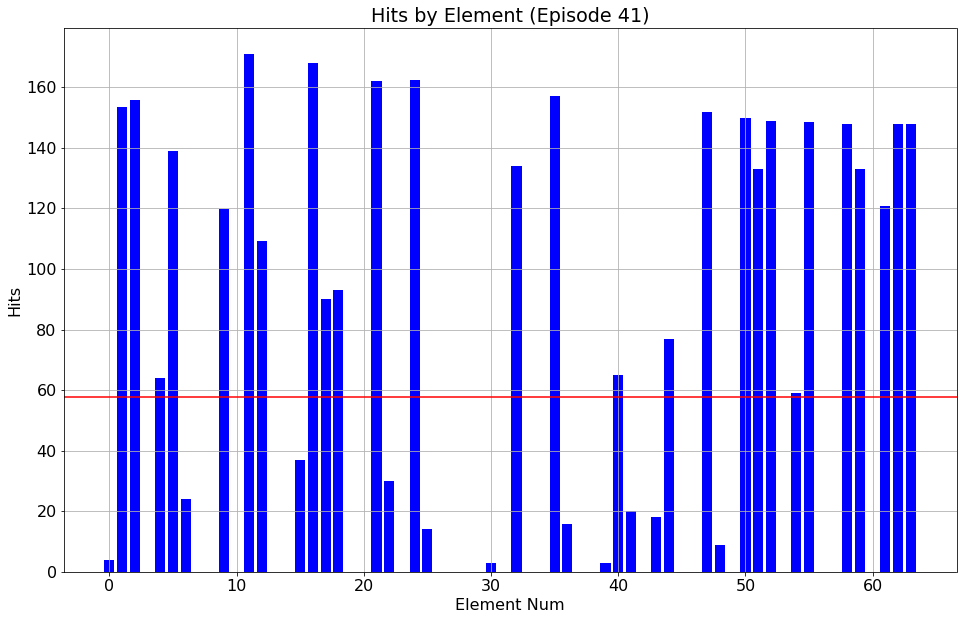

In [45]:
self.sieve_round(round=10, num_batches=num_batches_thawed, live_elts=True, 
                 learning_rate=learning_rate_thawed, min_learning_rate=min_learning_rate)

In [ ]:
# model.sieve()

In [ ]:
# model.load()

In [46]:
model.report()


Good elements (hits > 10):  34.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:   788.86  : 107.94 :    11.03 :   187.48
Mean     :      nan  :  57.64 :    94.19 :   280.82
Median   :      nan  :  17.00 :    21.95 :   329.33
GeoMean  :      nan  :  11.00 :    29.65 :   248.90
Std      :      nan  :  65.90 :   169.01 :   122.40
Min      :      nan  :   0.00 :     1.81 :    71.20
Max      :      nan  : 171.00 :  1004.67 :   400.00
Trained for 15100 batches over 151 epochs and 41 episodes.


## Distance vs. Nearest Asteroid for Fitted Elements

In [48]:
# _ = model.nearest_ast()

In [ ]:
model.report()

In [ ]:
# model.save_state()

In [49]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.mean(model.elts_near_ast.nearest_ast_q_norm[is_converged])

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 34 asteroids.
Mean on converged asteroids:
Number of hits         : 107.92
GeoMean Distance in AU : 1.55e-04
Covariance norm        : 2.20e-02


In [ ]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

In [ ]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [ ]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

In [ ]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

In [ ]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)